# Headers (load libaries/packages/functions needed)

In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [135]:
%matplotlib inline
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
#import plotly.express as px
import scipy as sp
import scipy.io as sio
from scipy.constants import N_A
from scipy.optimize import curve_fit
import h5py
import numpy as np
import pandas as pd
from pyitlib import discrete_random_variable as drv
import time
from IPython.display import Markdown, HTML, display

pass

In [34]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

In [35]:
#User-defined utility functions
def printmd(string):
    display(Markdown(string))
    
def plot_hist(X,binwidth,xlimv,xlabelv,fit):
    barStyles={"width":0.75*binwidth, "linewidth":0, "align":"center"}
    (bins,edges) = np.histogram(X,np.arange(-0.5*binwidth,np.max(X)+1.5*binwidth,binwidth))
    centers = (edges[:-1]+edges[1:])/2
    xdata=centers;ydata=bins/sum(bins)
    pdf = np.zeros((len(bins),2),dtype=float)
    pdf[:,0]=centers
    pdf[:,1] = bins.astype(double)/(np.sum(bins)*(centers[1]-centers[0]))

    bar(pdf[:,0],pdf[:,1], **barStyles,label='raw')
    if (fit==1):
        param=sp.stats.lognorm.fit(X)
        plt.plot(xdata, sp.stats.lognorm.pdf(xdata, param[0], loc=param[1], scale=param[2]), 'r-',label='lognormal fit')
        legend()
    xlim(-0.5*binwidth,xlimv)
    title(xlabelv); ylabel('pdf')
    
def cal_p_value(p_x,x):
    p_x = sorted(p_x)
    index = np.where(np.array(p_x)<x)[0][-1]+1
    p_value = 1.0-index/len(p_x)
    return p_value

# 1 load files

Here we load the .mat files (provided by Tianyou) to python. We merge the datasets from the 2018/10/10 experiment and the 2018/12/01 experiment. We look at the samples collected at different times after triggering (1,2,3,5,7.5,10,20,30,60,120,180 min). For each cell, we extract the following data:

* Par spot number (estimation of MOI)
* cell length
* cI mRNA copy number
* cII mRNA copy number
* cro mRNA copy number

In [36]:
column_names = ['len','moi','ci','cro','cii','time']
df = pd.DataFrame(columns = column_names)

#####################
filename1 = '20181010_infection_dataset_ty.mat'
filename2 = '20181201_infection_dataset_ty.mat'

time_after_triggering = [0.5,1,2,3,5,7.5,10,20,30,60,120,180]
column_id = [3,4,16,26,36]
for filename in [filename1,filename2]:
    mat_contents = sio.loadmat(filename)['enlistcell_total'];
    k = 0;
    for i in range(2,2+len(time_after_triggering)):
        tmp = mat_contents[0][i][:,column_id]
        tmp2=tmp[~np.isnan(tmp).any(axis=1)]
        tmp2=tmp2[tmp2[:,1]>0]
        df_tmp = pd.DataFrame(data=tmp2, 
                              index=[str(time_after_triggering[k])+'_'+str(i) for i in range(1,len(tmp2)+1)], 
                              columns=['len','moi','ci','cro','cii'])
        df_tmp['time']=np.full((len(tmp2),1),time_after_triggering[k])
        df = pd.concat([df,df_tmp])
        k = k+1;

df['len']=df['len']/(df['len'].median())
df['conc']= df['moi']/df['len']
printmd('**Number of samples at different time points:**')
print(df.groupby(['time'])['moi'].count())

**Number of samples at different time points:**

time
0.5       840
1.0      1003
2.0       534
3.0       702
5.0       769
7.5       800
10.0      416
20.0      737
30.0     1128
60.0     1254
120.0    1337
180.0     653
Name: moi, dtype: int64


## Data statistics
To make sure we extract the correct column, we show some basic statistics of the data: 

* the distribution of MOI, cell length normalized with median, viral concentration, cI/cII/cro mRNA copy number
* the mean mRNA copy number of cI/cII/cro at different MOI over time. 

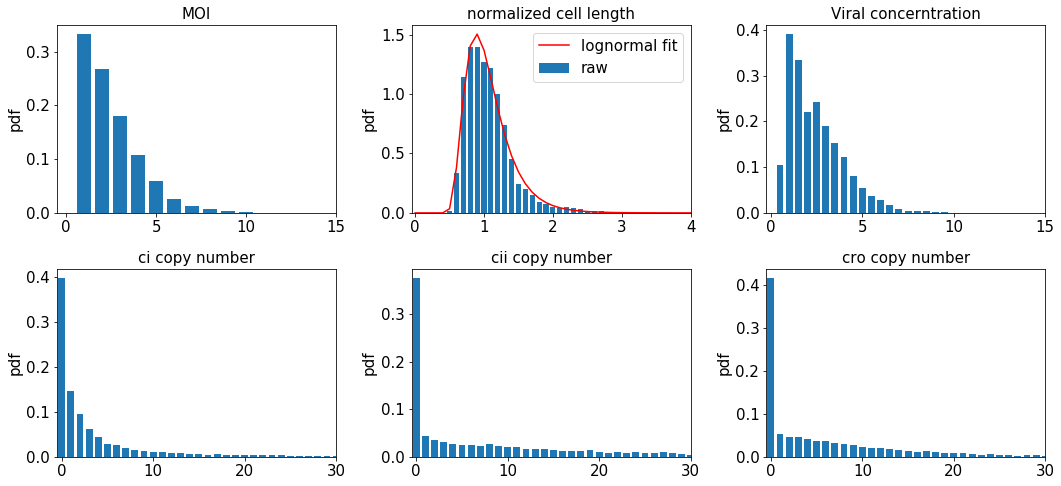

In [37]:
xlabelv_array = ['MOI','normalized cell length','Viral concerntration',
                 'ci copy number','cii copy number','cro copy number']
fit_array=[0,1,0,0,0,0]
binwidth_array=[1,0.1,0.5,1,1,1]
xlimv_array=[15,4,15,30,30,30]
k = 0;
matplotlib.rcParams.update({"figure.figsize": (15,7)})
for j in ['moi','len','conc','ci','cii','cro']:
    X = np.array(df[j].to_numpy())
    subplot(2,3,k+1)
    plot_hist(X,binwidth_array[k],xlimv_array[k],xlabelv_array[k],fit_array[k])
    k = k+1;
tight_layout()

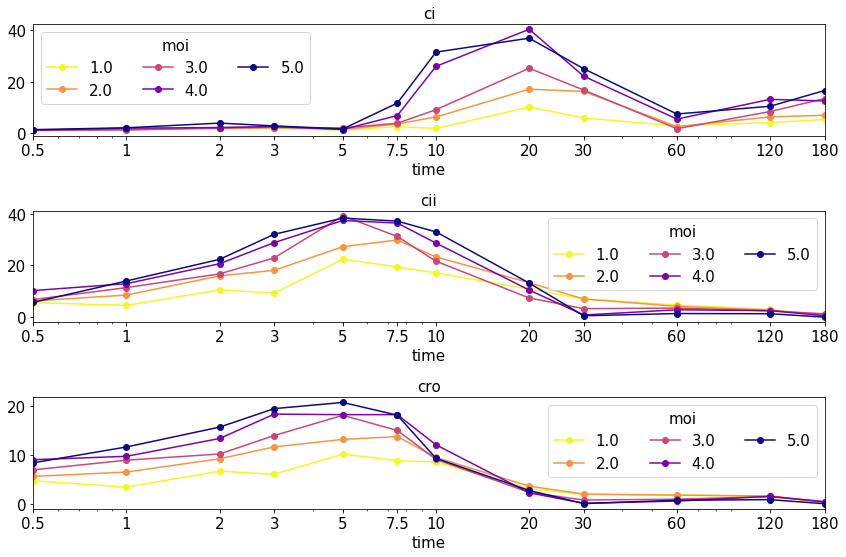

In [38]:
df2 = df
df2 = df2[df2['moi']<=5]
gene = ['ci','cii','cro']
matplotlib.rcParams.update({"figure.figsize": (12,8)})
fig, ax = plt.subplots(3, 1)
for i in range(0,len(gene)):
    ax[i].set_title(gene[i])
    ax[i].set_xscale('log')
    ax[i].set_xticks(time_after_triggering)
    ax[i].set_xticklabels([str(k) for k in time_after_triggering])
    df2.groupby(['time','moi']).mean()[gene[i]].unstack().plot(ax=ax[i],
                                                               cmap='plasma_r',
                                                               linestyle='solid', 
                                                               marker='o')
    if i == 0:
        ax[i].legend(title='moi',loc="upper left",ncol=3)
    else:
        ax[i].legend(title='moi',loc="upper right",ncol=3)
tight_layout()

# 2 Method to estimate mutual information (MI)
### 2.1 theoretial formula

For discrete random variables $X \sim p(x)$, and $Y \sim p(y)$, we have:

entropy: $H(X) = \sum _\chi p(x)\log p(x)$ (Note that $\chi$ denotes the set of all possible realizations of $X$)

joint entropy: $H(X,Y) = \sum _\chi \sum _\gamma p(x,y)\log p(x,y)$

mutual information: $I(X;Y) = H(X) + H(Y) - H(X,Y)$

(p.41-42, Cover & Thomas, Elements of Information Theory, 1991)

### 2.2 the maximum likelihood estimator of mutual information is biased

In reality, we don't know the true distribution of $X$ and $Y$, and we have to estimate them from finite observations (with sample size $N$). The maximum likelihood estimator of entropy (the empirical entropy) is: 

$\tilde{H_N}(X) = \sum _{\{a\}} \frac{N(x=a)}{N} \log \frac{N(x=a)}{N}$, 

where $N(x=a)$ is the time that $a$ appears. 

One can show that the empirical entropy and empirical mutual information is biased. (Paninski, Liam. "Estimation of entropy and mutual information." Neural computation 15.6 (2003): 1191-1253.)

### 2.3 unbiased mutual information estimation (the Miller-Madow estimator)

One can show that, when the number of non-zero bins of p(x), p(y), and p(x,y) (denotated as $m_x$, $m_y$, $m_{xy}$ respectively) is fixed, 

$\tilde{I_N}(X;Y) = I(X;Y) - \frac{1}{N}\cdot \frac{m_{xy}-m_x-m_y-1}{2} + O(\frac{1}{N})$, 

where $I(X;Y)$ is the true mutual information and $\tilde{I_N}(X;Y)$ is the empirical estimator based on $N$ samples. If we omit the higher order terms, $\tilde{I_N}(X;Y)$ is just a linear function of $\frac{1}{N}$, and the $y$ intercept of the function (correponding to an infinite sample size) should be the true $I(X;Y)$. Using this method, as N goes to infinity, the error goes to 0. 

We could therefore:

<font color='red'>1) subset the original dataset with sample size $N_1<N_2<...<N$, and for each $N_i$, calculate $\tilde{I_{N_i}}(X;Y)$;</font>

<font color='red'>2) fit pairs ($\frac{1}{N_i}$, $\tilde{I_{N_i}}(X;Y)$) with a linear function; </font>

<font color='red'>3) extract the $y$ intercept of the fitted function, which is the true mutual information $I(X;Y)$. </font>

(Paninski, Liam. "Estimation of entropy and mutual information." Neural computation 15.6 (2003): 1191-1253.)

### 2.4 normalized mutual information
Normalized mutual information (NMI) is defined as the mutual information between X and Y over the total entropy: $NMI(X;Y) = \frac{I(X;Y)}{H(X,Y)}$. Although this quantity is rarely mentioned in the classic testbook, it could be understood as the information theoretic correspondence of Pearson correlation coefficient. NMI captures the nonlinear dependence between X and Y. Therefore we also calculated NMI for our data, just for reference. 

In [91]:
#calculate entropy based on a distribution
def shan_entropy(c):
    c_normalized = c/float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

#calculate empirical mutual information between X and Y
def calc_MI(X,Y,binwidth):
    c_XY = np.histogram2d(X,Y,[np.arange(-0.5*binwidth+np.min(X),np.max(X)+1.5*binwidth,binwidth), np.arange(-0.5,np.max(Y)+1.5,1)])[0]
    c_X = np.histogram(X,np.arange(-0.5*binwidth+np.min(X),np.max(X)+1.5*binwidth,binwidth))[0]
    if (np.max(Y)==0):
        return 0
    else:
        c_Y = np.histogram(Y,np.arange(-0.5,np.max(Y)+1.5,1))[0]
        H_X = shan_entropy(c_X)
        H_Y = shan_entropy(c_Y)
        H_XY = shan_entropy(c_XY)
        H_total = H_X+H_Y
        MI = H_X + H_Y - H_XY
        return (MI, H_total)

#calculate empirical mutual information between (X1,X2) and Z
def I_X1_X2_wrt_Z(X1,X2,Z):
    H_X1_X2 = drv.entropy_joint(np.array((X1,X2)), estimator='ML')
    H_X1_X2_Z = drv.entropy_joint(np.array((X1,X2,Z)), estimator='ML')
    H_Z = drv.entropy(Z, estimator='ML')   
    I = H_X1_X2 + H_Z - H_X1_X2_Z    
    return I

#calculate empirical mutual information between (X1,X2,X3) and Z
def I_X1_X2_X3_wrt_Z(X1,X2,X3,Z):
    H_X1_X2_X3 = drv.entropy_joint(np.array((X1,X2,X3)), estimator='ML')
    H_X1_X2_X3_Z = drv.entropy_joint(np.array((X1,X2,X3,Z)), estimator='ML')
    H_Z = drv.entropy(Z, estimator='ML')
    
    I = H_X1_X2_X3 + H_Z - H_X1_X2_X3_Z
    return I    

In [92]:
def linear(x,a,b):
    return (a*x+b)

def plot_MI2(xdata,ydata,popt_MI,gene_name,t):
    matplotlib.rcParams.update({"figure.figsize": (5,4)})
    plt.plot(xdata,ydata,'o',**plotStyles,label='raw')
    plt.plot(xdata,linear(xdata,*popt_MI),'r-',linewidth=2,label='fit')
    plt.title('MI='+str(round(popt_MI[1],2)))
    tight_layout()
    plt.savefig('check2/MI2_'+gene_name+'_'+str(t)+'.pdf')
    plt.close()

#calculate true mutual information
def get_MI(counts,binwidth,gene_name,t,save_figure):
    index = range(0,len(counts[:,0]))
    size = np.array([1,0.8,0.7,0.6,0.5])*len(counts[:,0]);
    size = size.astype(int)
    xdata = 1.0/size;
    ydata = np.array([], dtype=float)
    zdata = np.array([], dtype=float)
    N_sample = 500
    for j in size:
        temp_MI = np.zeros(N_sample)
        temp_H = np.zeros(N_sample)
        for N in range(0,N_sample):
            index_2 = np.random.choice(index, j,replace=True);
            (temp_MI[N], temp_H[N]) = calc_MI(counts[index_2,0], counts[index_2,1],binwidth);
        ydata = np.append(ydata, np.mean(temp_MI));
        zdata = np.append(zdata, np.mean(temp_H));
    popt_MI, pcov_MI = curve_fit(linear, xdata, ydata)
    popt_H, pcov_H = curve_fit(linear, xdata, zdata)
    
    if (save_figure==1):
        matplotlib.rcParams.update({"figure.figsize": (5,4)})
        plt.plot(xdata,ydata,'o',**plotStyles,label='raw')
        plt.plot(xdata,linear(xdata,*popt_MI),'r-',linewidth=2,label='fit')
        plt.title('MI='+str(round(popt_MI[1],2)))
        tight_layout()
        plt.savefig('check2/MI_'+gene_name+'_'+str(t)+'.pdf')
        plt.close()        
        matplotlib.rcParams.update({"figure.figsize": (5,4)})
        plt.plot(xdata,zdata,'o',**plotStyles,label='raw')
        plt.plot(xdata,linear(xdata,*popt_H),'r-',linewidth=2,label='fit')
        plt.title('H='+str(round(popt_H[1],2)))
        tight_layout()
        plt.savefig('check2/H_'+gene_name+'_'+str(t)+'.pdf')
        plt.close()
    
    return (popt_MI[1], popt_H[1])
        
def cal_I_X1_X2_wrt_Z(X1,X2,X3,Z,t,save_figure):
    size = np.array([1,0.8,0.7,0.6,0.5])*len(X1);
    size = size.astype(int)
    index = range(0,len(X1))
    xdata = 1.0/size;
    ydata1 = np.array([], dtype=float)
    ydata2 = np.array([], dtype=float)
    ydata3 = np.array([], dtype=float)
    N_sample = 500
    for j in size:
        temp_MI1 = np.zeros(N_sample);temp_MI2 = np.zeros(N_sample);temp_MI3 = np.zeros(N_sample)
        for N in range(0,N_sample):
            index_2 = np.random.choice(index, j,replace=True);
            X1_ = X1[index_2]; X2_ = X2[index_2]; X3_ = X3[index_2]; Z_ = Z[index_2];
            temp_MI1[N] = I_X1_X2_wrt_Z(X1_, X2_, Z_)
            temp_MI2[N] = I_X1_X2_wrt_Z(X1_, X3_, Z_)
            temp_MI3[N] = I_X1_X2_wrt_Z(X2_, X3_, Z_)
        ydata1 = np.append(ydata1, np.mean(temp_MI1));
        ydata2 = np.append(ydata2, np.mean(temp_MI2));
        ydata3 = np.append(ydata3, np.mean(temp_MI3));
    popt_MI1, pcov_MI1 = curve_fit(linear, xdata, ydata1)
    popt_MI2, pcov_MI2 = curve_fit(linear, xdata, ydata2)
    popt_MI3, pcov_MI3 = curve_fit(linear, xdata, ydata3)
    if (save_figure==1):
        plot_MI2(xdata,ydata1,popt_MI1,'ci_cii',t);
        plot_MI2(xdata,ydata2,popt_MI2,'ci_cro',t);
        plot_MI2(xdata,ydata3,popt_MI3,'cii_cro',t);
    
    return (popt_MI1[1], popt_MI2[1], popt_MI3[1])
        
def cal_I_X1_X2_X3_wrt_Z(X1,X2,X3,Z,t,save_figure):
    size = np.array([1,0.8,0.7,0.6,0.5])*len(X1);
    size = size.astype(int)
    index = range(0,len(X1))
    xdata = 1.0/size;
    ydata = np.array([], dtype=float)
    N_sample = 500
    for j in size:
        temp_MI = np.zeros(N_sample);
        for N in range(0,N_sample):
            index_2 = np.random.choice(index, j,replace=True);
            X1_ = X1[index_2]; X2_ = X2[index_2]; X3_ = X3[index_2]; Z_ = Z[index_2];
            temp_MI[N] = I_X1_X2_X3_wrt_Z(X1_,X2_,X3_,Z_)
        ydata = np.append(ydata, np.mean(temp_MI));
    popt_MI, pcov_MI = curve_fit(linear, xdata, ydata)
    if (save_figure==1):
        plot_MI2(xdata,ydata,popt_MI,'ci_cii_cro',t);
    
    return popt_MI[1]

### 2.3 verify the code

We want to make sure that our code is correct, by checking the result with some ground truth. For example, for X = [1,2,3,4,5,6,7,8], Y = [4,3,2,1,0,0,0,0], the mutual information between X and Y should be 2 bits, since Y could only distinguish between $2^2 = 4$ different conditions of X. 


In [40]:
X = [1,2,3,4,5,6,7,8]; Y = [4,3,2,1,0,0,0,0];
print(calc_MI(X,Y,1)[0])

2.0


We also want to compare the speed of our code with an existing library pyitlib https://pypi.org/project/pyitlib/. 

In [138]:
X = np.array(df3['ci'].to_numpy());Y = np.array(df3['moi'].to_numpy());X = np.rint(X)

printmd('**pyitlib (existing library):**')
tic=time.time()
print('empirical MI between MOI and CII: '+str(round(drv.information_mutual(X,Y,cartesian_product=False,estimator='ML'),4)))
toc=time.time()
print('running time: '+str(round(toc-tic,5))+' s')

printmd('**our code:**')
tic=time.time()
print('empirical MI between MOI and CII: '+str(round(calc_MI(X,Y,1)[0],4)))
toc=time.time()
print('running time: '+str(round(toc-tic,5))+' s')

**pyitlib (existing library):**

empirical MI between MOI and CII: 0.1502
running time: 0.028 s


**our code:**

empirical MI between MOI and CII: 0.1502
running time: 0.00628 s


In the empirical mutual information estimation, our code is about 10 times faster than pyitlib.

## Summary: 

### We build an unbiased mutual information estimator for discrete random variables. 

# 3 Does cI/cII/cro count MOI?

Here we look at the mutual information between single-cell MOI and cI/cII/cro mRNA copy number. We merge the data collected no later than 30 min.

Note that after 30 min, some cells might already lysogenize and resume the cell cycle, so the Par spot number might not reflect the original infecting number. 

In [139]:
df3 = df
df3 = df3[df3['time']<=30]
gene = ['ci','cii','cro']
MI_data = np.zeros(len(gene));NMI_data = np.zeros(len(gene))
filenames = ['files1/alltime_MI_data_r.csv','files1/alltime_NMI_data_r.csv']

for g_i in range(0,len(gene)):  
    MOI = np.array(df3['moi'].to_numpy())
    mRNA = np.array(df3[gene[g_i]].to_numpy())
    counts = np.vstack((MOI,mRNA)).T
    (MI,H) = get_MI(counts,1, gene[g_i],0,1)
    MI_data[g_i] = MI
    NMI_data[g_i] = MI/H
'''
    MI_all = np.zeros(100); NMI_all = np.zeros(100);
    for r_i in range(0,100):
        mRNA2 = np.array(mRNA);
        mRNA2 = np.random.choice(mRNA2,len(mRNA2),replace=True)
        counts2 = np.vstack((MOI,mRNA2)).T
        (MI2,H2) = get_MI(counts2,1,gene[g_i],0,0)
        MI_all[r_i] = MI2; NMI_all[r_i] = MI2/H2;
    filename_ = 'files1/alltime_'+str(gene[g_i])+'.csv'
    np.savetxt(filename_, np.vstack((MI_all,NMI_all)).T, delimiter=",")
    
filename_ = 'files1/alltime_MI_NMI.csv'
np.savetxt(filename_, np.vstack((MI_data,NMI_data)).T, delimiter=",")
'''

'\n    MI_all = np.zeros(100); NMI_all = np.zeros(100);\n    for r_i in range(0,100):\n        mRNA2 = np.array(mRNA);\n        mRNA2 = np.random.choice(mRNA2,len(mRNA2),replace=True)\n        counts2 = np.vstack((MOI,mRNA2)).T\n        (MI2,H2) = get_MI(counts2,1,gene[g_i],0,0)\n        MI_all[r_i] = MI2; NMI_all[r_i] = MI2/H2;\n    filename_ = \'files1/alltime_\'+str(gene[g_i])+\'.csv\'\n    np.savetxt(filename_, np.vstack((MI_all,NMI_all)).T, delimiter=",")\n    \nfilename_ = \'files1/alltime_MI_NMI.csv\'\nnp.savetxt(filename_, np.vstack((MI_data,NMI_data)).T, delimiter=",")\n'

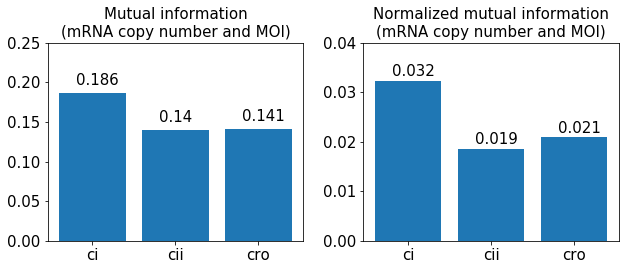

In [43]:
tmp = np.genfromtxt('files1/alltime_MI_NMI.csv',delimiter=',')
MI_data = tmp[:,0]
NMI_data = tmp[:,1]

%matplotlib inline
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

x_ = np.arange(0.5,3.5)
matplotlib.rcParams.update({"figure.figsize": (9,4)})
subplot(1,2,1)
bar(x_,MI_data,label='raw');#bar(x_,MI_data_r[:,0],yerr=MI_data_r[:,1],color='black',ecolor='white',label='scrambled');
for i in range(0,len(x_)):
    text(x_[i]-0.2,MI_data[i]+0.01,str(round(MI_data[i],3)))
xticks(x_,gene);title('Mutual information\n(mRNA copy number and MOI)');ylim(0,0.25);

subplot(1,2,2)
bar(x_,NMI_data,label='raw');#bar(x_,NMI_data_r[:,0],yerr=NMI_data_r[:,1],color='black',ecolor='white',label='scrambled');
for i in range(0,len(x_)):
    text(x_[i]-0.2,NMI_data[i]+0.001,str(round(NMI_data[i],3)))
xticks(x_,gene);title('Normalized mutual information\n(mRNA copy number and MOI)');ylim(0,0.04);
tight_layout()

## statistical significance of mutual information between MOI and transcription
For each gene, the mutual information between its mRNA copy number and MOI is nonzero. However, this non-zero value could also come from chance. 

To test how much it could be from chance, 

1) we set the null hypothesis $H_0$ as "there's no statistical dependence of MOI and mRNA copy number";

2) to generate the distribution of mutual information under $H_0$, 

* we scramble the data: for a given gene, we keep the original MOI for each sample the same, but assign it with a random mRNA copy number drawn from the mRNA copy number distribution of that gene; 

* we then calculate the distribution of mutual information from scrambled data $p_0(I_{scrambled})$; to obtain a distribution, we scramble the data 100 times; 

3) finally, we caculate the p-value of our observed mutual information $I_{obs}$ by $p_0(I_{scrambled}>I_{obs})$. 

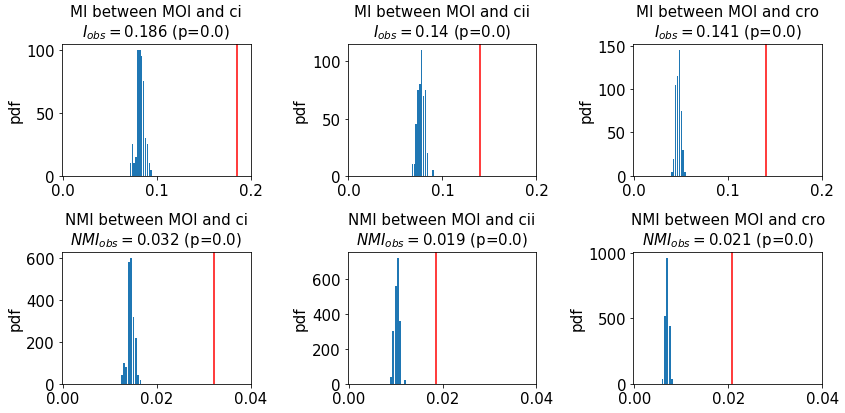

In [435]:
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

p_MI = np.zeros(len(gene)); p_NMI = np.zeros(len(gene));
MI_data_r = np.zeros((len(gene),2));NMI_data_r = np.zeros((len(gene),2))
matplotlib.rcParams.update({"figure.figsize": (12,6)})
for g_i in range(0,len(gene)):
    filename_ = 'files1/alltime_'+str(gene[g_i])+'.csv'
    scrambled_data = np.genfromtxt(filename_,delimiter=',')
    MI_all = scrambled_data[:,0]; NMI_all = scrambled_data[:,1]
    p_MI[g_i]=cal_p_value(MI_all,MI_data[g_i])
    p_NMI[g_i]=cal_p_value(NMI_all,NMI_data[g_i]) 
    MI_data_r[g_i,:] = (np.mean(MI_all), np.std(MI_all))
    NMI_data_r[g_i,:] = (np.mean(NMI_all), np.std(NMI_all))

    subplot(2,3,g_i+1)
    plot_hist(MI_all,0.002,0.20,'MI between MOI and '+gene[g_i]+'\n'+r'$I_{obs}=$'+str(round(MI_data[g_i],3))+' (p='+str(p_NMI[g_i])+')',0)
    plt.axvline(MI_data[g_i],color='red')
    
    subplot(2,3,g_i+4)
    plot_hist(NMI_all,0.0005,0.04,'NMI between MOI and '+gene[g_i]+'\n'+r'$NMI_{obs}=$'+str(round(NMI_data[g_i],3))+' (p='+str(p_NMI[g_i])+')',0)
    plt.axvline(NMI_data[g_i],color='red')
tight_layout()

In the above plot, the null distribution is plotted in blue, and the observed mutual information ($I_{obs}$) is denoted with the red line. 


## Summary: 

### 1. We develop a method to calculate the statistical significance of mutual information. 

### 2. cI, cII, cro all count MOI. However, on time average, they count badly. For all three genes, the MI between MOI and mRNA copy number is very close to 0.  We'd like to check the time-specific performance of counting. 

# 4 When does cI/cII/cro count MOI best? 

It could be possible that cI, cII, and cro counts MOI better at some time points than at other time points. We look at the mutual information between MOI and copy number of cI, cII, and cro at different time points (0.5,1,2,3,5,7.5,10,20,30 min). 

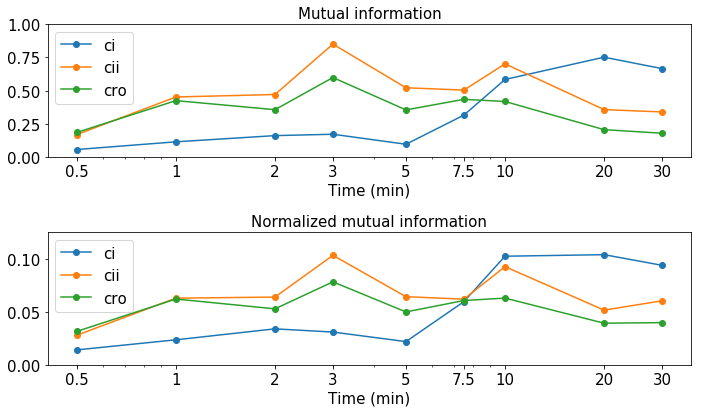

In [93]:
df3 = df #df3 = df3[df3['time']<60]
time_after_triggering3 = [0.5,1,2,3,5,7.5,10,20,30,60,120,180]
gene = ['ci','cii','cro']

MI_data = np.zeros((len(gene),len(time_after_triggering3)))
NMI_data = np.zeros((len(gene),len(time_after_triggering3)))

for g_i in range(0,len(gene)):
    for t_i in range(0,len(time_after_triggering3)):   
        df4 = df3[df3['time']==time_after_triggering3[t_i]]
        MOI = df4['moi']
        mRNA = df4[gene[g_i]]
        counts = np.vstack((MOI,mRNA)).T
        (MI,H) = get_MI(counts,1, gene[g_i],time_after_triggering3[t_i],1)
        MI_data[g_i,t_i] = MI
        NMI_data[g_i,t_i] = MI/H
    filename_ = 'files1/'+gene[g_i]+'.csv'
    np.savetxt(filename_, np.vstack((MI_data[g_i,:],NMI_data[g_i,:])).T, delimiter=",")         

%matplotlib inline
import matplotlib
from pylab import *
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering4 = [0.5,1,2,3,5,7.5,10,20,30]
matplotlib.rcParams.update({"figure.figsize": (10,6)})
subplot(2,1,1)
for i in range(0,len(gene)):
    plot(time_after_triggering4,MI_data[i,:-3],'o-',label=gene[i])    
xscale('log');xlabel('Time (min)');xticks(time_after_triggering4,[str(k) for k in time_after_triggering4])
title('Mutual information');legend(ncol=1)
ylim(0,1.0)

subplot(2,1,2)
for i in range(0,len(gene)):
    plot(time_after_triggering4,NMI_data[i,:-3],'o-',label=gene[i]) 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering4,[str(k) for k in time_after_triggering4])
title('Normalized mutual information');legend(ncol=1)
ylim(0,0.125)

tight_layout()

## statistical significance of mutual information between MOI and transcription

In [441]:
'''
df3 = df
for g_i in range(0,len(gene)):
    for t_i in range(0,len(time_after_triggering3)):
        df4 = df3[df3['time']==time_after_triggering3[t_i]]
        MOI = df4['moi'].to_numpy()
        mRNA = df4[gene[g_i]].to_numpy()
        MI_all = np.zeros(100); NMI_all = np.zeros(100);
        for r_i in range(0,100):
            mRNA2 = np.array(mRNA)
            mRNA2 = np.random.choice(mRNA2,len(mRNA2),replace=True)
            counts = np.vstack((MOI,mRNA2)).T
            (MI2,H2) = get_MI(counts,1,gene[g_i],time_after_triggering3[t_i],0)
            MI_all[r_i] = MI2; NMI_all[r_i] = MI2/H2;
        filename_ = 'files1/'+str(gene[g_i])+'_'+str(time_after_triggering3[t_i])+'.csv'
        np.savetxt(filename_, np.vstack((MI_all,NMI_all)).T, delimiter=",")   
'''

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


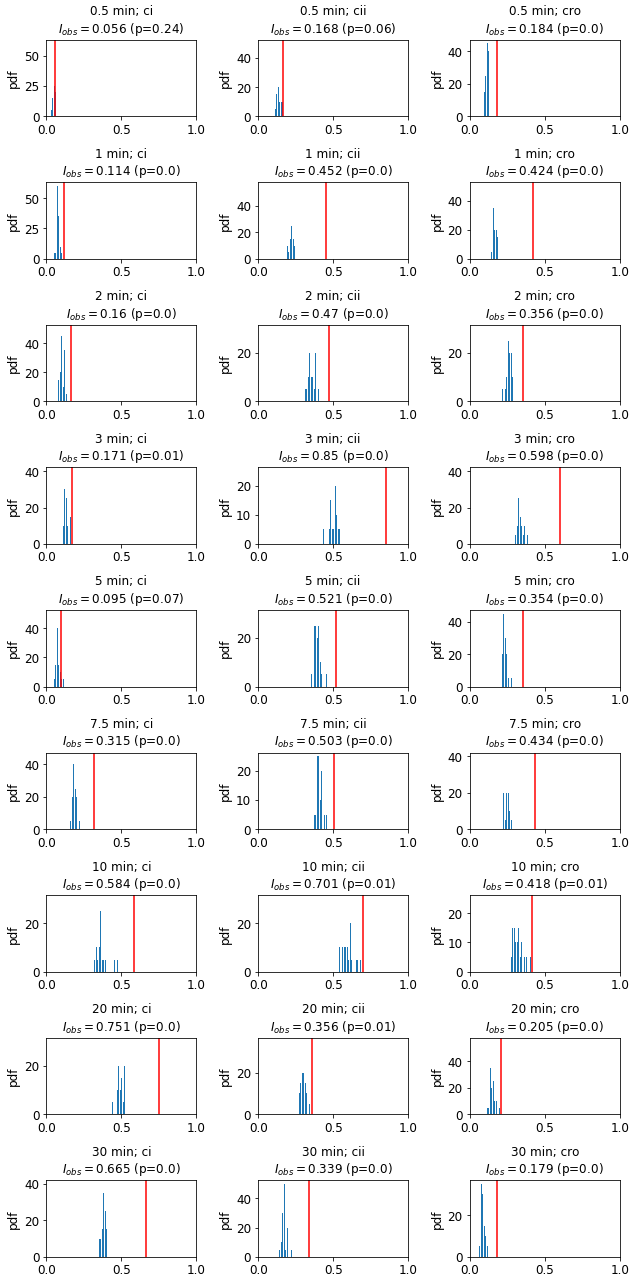

In [120]:
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
fontSize=12
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

matplotlib.rcParams.update({"figure.figsize": (9,18)})
for g_i in range(0,len(gene)):
    filename_ = 'files1/'+gene[g_i]+'.csv'
    MI_data2 = np.genfromtxt(filename_,delimiter=',')[:,0]
    for t_i in range(0,len(time_after_triggering3[:-3])):
        filename_ = 'files1/'+str(gene[g_i])+'_'+str(time_after_triggering3[t_i])+'.csv'
        scrambled_data = np.genfromtxt(filename_,delimiter=',')
        MI_all = scrambled_data[:,0];
        p_MI=cal_p_value(MI_all,MI_data2[t_i])
        subplot(len(time_after_triggering3[:-3]),3,g_i+3*t_i+1)        
        plot_hist(MI_all,0.002,1.0,str(time_after_triggering3[t_i])+' min; '+gene[g_i]+'\n'+r'$I_{obs}=$'+str(round(MI_data2[t_i],3))+' (p='+str(round(p_MI,3))+')',0)
        plt.axvline(MI_data2[t_i],color='red')

tight_layout()

# 5 Do multiple genes count better than single gene?

## 5.1 Single gene couldn't distinguish between 2 levels of MOI

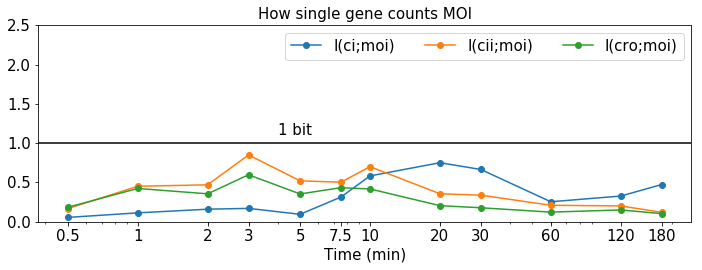

In [130]:
matplotlib.rcParams.update({"figure.figsize": (10,4)})
for i in range(0,len(gene)):
    filename_ = 'files1/'+gene[i]+'.csv'
    MI_data_single = np.genfromtxt(filename_,delimiter=',')[:,0]
    plot(time_after_triggering3,MI_data_single,'o-',label='I('+gene[i]+';moi)')
xscale('log');xlabel('Time (min)');xticks(time_after_triggering3,[str(k) for k in time_after_triggering3])
axhline(1,color='black'); text(4,1.1,'1 bit')
title('How single gene counts MOI');legend(ncol=3)
ylim(0,2.5)
tight_layout()

## 5.2 two genes could distinguish between 4 levels of MOI at best

In [113]:
df3 = df #df3 = df3[df3['time']<60]
time_after_triggering3 = [0.5,1,2,3,5,7.5,10,20,30,60,120,180]
gene = ['ci','cii','cro']

MI_data1 = np.zeros(len(time_after_triggering3))
MI_data2 = np.zeros(len(time_after_triggering3))
MI_data3 = np.zeros(len(time_after_triggering3))

for t_i in range(0,len(time_after_triggering3)):   
    df4 = df3[df3['time']==time_after_triggering3[t_i]]
    X1 = np.array(df4['ci'].to_numpy());X1 = np.rint(X1)
    X2 = np.array(df4['cii'].to_numpy());X2 = np.rint(X2)
    X3 = np.array(df4['cro'].to_numpy());X3 = np.rint(X3)   
    Z = np.array(df4['moi'].to_numpy());
    (MI_data1[t_i], MI_data2[t_i], MI_data3[t_i]) = cal_I_X1_X2_wrt_Z(X1,X2,X3,Z,time_after_triggering3[t_i],1)
np.savetxt('files1/ci_cii.csv', MI_data1, delimiter=",")
np.savetxt('files1/ci_cro.csv', MI_data2, delimiter=",")
np.savetxt('files1/cii_cro.csv', MI_data3, delimiter=",")

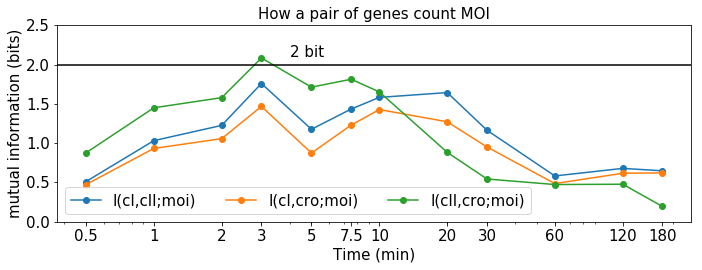

In [129]:
MI_data1 = np.genfromtxt('files1/ci_cii.csv',delimiter=',')
MI_data2 = np.genfromtxt('files1/ci_cro.csv',delimiter=',')
MI_data3 = np.genfromtxt('files1/cii_cro.csv',delimiter=',')

fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering4 = [0.5,1,2,3,5,7.5,10,20,30]
matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering3,MI_data1,'o-',label='I(cI,cII;moi)') 
plot(time_after_triggering3,MI_data2,'o-',label='I(cI,cro;moi)') 
plot(time_after_triggering3,MI_data3,'o-',label='I(cII,cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering3,[str(k) for k in time_after_triggering3])
title('How a pair of genes count MOI');legend(ncol=3,loc='lower left')
axhline(2,color='black');text(4,2.1,'2 bit')
ylabel('mutual information (bits)')
ylim(0,2.5)
tight_layout()

## 5.3 three genes could distinguish between 5 levels of MOI at best

In [116]:
df3 = df #df3 = df3[df3['time']<60]
time_after_triggering3 = [0.5,1,2,3,5,7.5,10,20,30,60,120,180]
gene = ['ci','cii','cro']

MI_data4 = np.zeros(len(time_after_triggering3))

for t_i in range(0,len(time_after_triggering3)):   
    df4 = df3[df3['time']==time_after_triggering3[t_i]]
    X1 = np.array(df4['ci'].to_numpy());X1 = np.rint(X1)
    X2 = np.array(df4['cii'].to_numpy());X2 = np.rint(X2)
    X3 = np.array(df4['cro'].to_numpy());X3 = np.rint(X3)   
    Z = np.array(df4['moi'].to_numpy());
    MI_data4[t_i] = cal_I_X1_X2_X3_wrt_Z(X1,X2,X3,Z,time_after_triggering3[t_i],1); 
np.savetxt('files1/ci_cii_cro.csv', MI_data4, delimiter=",")


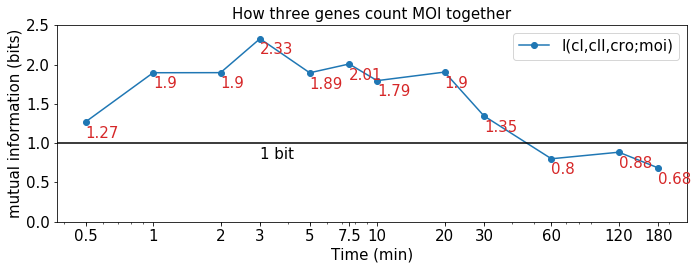

In [134]:
MI_data4 = np.genfromtxt('files1/ci_cii_cro.csv',delimiter=',')

fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})

time_after_triggering4 = [0.5,1,2,3,5,7.5,10,20,30]
matplotlib.rcParams.update({"figure.figsize": (10,4)})
plot(time_after_triggering3,MI_data4,'o-',label='I(cI,cII,cro;moi)') 
xscale('log');xlabel('Time (min)');xticks(time_after_triggering3,[str(k) for k in time_after_triggering3])
for i in range(0,len(time_after_triggering3)):
    text(time_after_triggering3[i],MI_data4[i]-0.2,str(round(MI_data4[i],2)),color='tab:red')
title('How three genes count MOI together');
legend(ncol=3,loc='upper right')
axhline(1,color='black'); text(3,0.8,'1 bit')
ylabel('mutual information (bits)')
ylim(0,2.5)
tight_layout()